# COGS 108 - Final Project 

# Overview

This project serves to determine the relationship between environmental health and the presence of parks within San Diego communities. The datasets used included thorough environmental health screenings for California locations and a set of park locations in different parts of San Diego.

# Name & GitHub ID

- Name: Dylan Cokic
- GitHub Username: dylpc

# Research Question

Does the establishment of parks in San Diego communities directly improve their overall environmental health?

## Background and Prior Work

As it is known that parks promote environmental quality and health, this study will consider whether parks play a significant role in boosting the overall health quality of communities in San Diego. 
One way parks benefit the environment is that they bring more nature to their communities, especially through trees. This is significant in that trees can largely improve air quality through their oxygen production, thus reducing pollution and the risk of physical illness [5]. Another benefit is that by increasing the rates of outdoor activity, parks can help strengthen people's health by reducing the risk of various diseases, prolonging one's lifespan, and improving mental health [1]. 
Noting the relation between these factors and the presence of parks in various San Diego communities will help determine whether there is a direct relationship between park establishment and healthy living (as measured by environmental health screenings).

References (include links):
- 1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3091337/
- 2) https://www.americantrails.org/resources/improving-public-health-through-public-parks-and-trails
- 3) https://data.sandiegocounty.gov/Environment/A-2-2-Increase-County-Tree-Planting/4yft-ep46
- 4) https://www.sandiegocounty.gov/hhsa/programs/phs/community_health_statistics/
- 5) https://www.cdc.gov/healthyplaces/healthtopics/parks.htm#:~:text=The%20physical%20activity%20you%20get,control%20your%20weight

# Hypothesis


I hypothesize that parks do improve the overall environmental health of communities in San Diego, as their presence improves air quality and leads to lower pollution levels.

# Dataset(s)

Two datasets were used for this analysis: San Diego parks and recreation location data, and California environmental health screening data.

- Dataset Name: SD Parks Locations
- Link to the dataset: https://data.sandiego.gov/datasets/park-locations/
- Number of observations: 2770
- Description: The locations of parks in San Diego are provided. The file was converted to the csv format prior to data analysis.

- Dataset Name: CalEnviroScreen 2.0
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8036
- Description: Various communities in California are screened for environmental health via their water, waste, pollution, asthma levels, poverty levels, and more. All of these variables are used to calculate their CalEnviroScreen score, which determines their overall health.

The two datasets will be used to compare the relative environmental health levels of different communities with respect to the prominence of parks within them. This allows me to determine whether their is a relationship between park presence and overall environmental health. Additionally, looking at individual variables in the health screening dataset will be useful in determining possible outliers and oddities in the analysis, as factors such as employment rate and poverty may be confounds.

# Setup

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
import patsy
import statsmodels.api as sm

#read data
df_env = pd.read_csv("calenviroscreen-final-report.csv")
df_parks = pd.read_csv("parks_datasd.csv")

# Data Cleaning

   First, I stripped the datasets of information that would be unnecessary for this particular analysis. For the environmental screening dataset, I removed most of the columns for the individual variables being screened (such as drinking water, low birth weight, traffic) because all of these variables were used to calculate their CES (CalEnviroScreen) score and this is the main factor I will be using for my conclusions. However, I left in a few columns such as asthma, pollution, and poverty levels -- which were scored by the relative lack of these issues -- as they may be useful in the final analysis. I also dropped the rows of locations other than San Diego, as this analysis is based on San Diego communities and there is enough pertinent data to draw viable conclusions. For the parks dataset, I removed coordinates as the park locations can be determined by their names and community owners. I also removed the park type column as knowing whether it is state-owned or local-owned is not relevant to this analysis.
   After this, I merged the two datasets into one, then proceeded to clean that one by further eliminating unnecessary information and organizing the rest. As both datasets provided park locations, I merged them on the basis of zip codes (as this was the most shared element between them) so that the combined data could provide information by park location. This allowed me to determine the average overall CES score by area and view its relationship with other variables. I also averaged the scores for the other variables, except for park acres per zip code (which I summed up) and the number of parks per zip code (I counted the size).
   The cleaning process is written step-by-step in the code comments.
   
   Note: for variables like asthma, pollution, etc, a higher score indicates better environmental health in this area.

In [2]:
#drop columns from environmental health screening dataset
df_env = df_env.drop(["Census Tract", "Click for interactive map", "Hyperlink", "Ozone", "Ozone Pctl", "PM2.5", "PM2.5 Pctl", "Diesel PM", "Diesel PM Pctl", "Drinking Water", "Drinking Water Pctl", "Pesticides", "Pesticides Pctl", "Tox. Release", "Tox. Release Pctl", "Traffic", "Traffic Pctl", "Cleanup Sites", "Cleanup Sites Pctl", "Groundwater Threats", "Groundwater Threats Pctl", "Haz. Waste", "Haz. Waste Pctl", "Imp. Water Bodies", "Imp. Water Bodies Pctl", "Solid Waste", "Solid Waste Pctl", "Pollution Burden", "Pollution Burden Pctl", "Age Pctl", "Asthma Pctl", "Low Birth Weight", "Low Birth Weight Pctl", "Education", "Education Pctl", "Linguistic Isolation", "Linguistic Isolation Pctl", "Poverty Pctl", "Unemployment Pctl", "Pop. Char. ", "Pop. Char. Score", "Pop. Char. Pctl"], axis=1)

#drop non-san diego rows
df_env = df_env[(df_env["California County"] == "San Diego")]
df_env["location"] = df_env["Location 1"].str[9:15]
df_env = df_env.drop(["Location 1"], axis=1)
df_env["location"] = df_env["location"].str[:6]

#get zip codes, drop rows missing zip code from location column
df_env["location"] = df_env["location"].apply(pd.to_numeric, errors='coerce')
df_env["location"] = df_env["location"].dropna()
env_drop = (pd.isna(df_env["location"]) == True)
df_env["loc"] = env_drop
df_env = df_env.drop(df_env[df_env["loc"] == True].index, inplace=False)
df_env = df_env.drop(["loc"], axis=1)

In [3]:
df_env

,Total Population,California County,CES 2.0 Score,CES 2.0 Percentile Range,Pollution Burden Score,Age,Asthma,Poverty,Unemployment,location
165,2227,San Diego,59.91,96-100% (highest scores),7.203297,23.8,81.370000,74.855946,NaN,92113.0
299,3250,San Diego,55.61,96-100% (highest scores),6.645896,24.9,81.370000,76.636392,17.84,92113.0
370,5028,San Diego,54.23,96-100% (highest scores),6.738271,24.9,81.370000,70.019802,13.77,92113.0
466,4927,San Diego,52.48,91-95%,6.190205,24.2,81.370000,76.470588,19.39,92113.0
805,4241,San Diego,47.82,86-90%,5.612438,24.3,80.064873,79.242069,28.52,92113.0
...,...,...,...,...,...,...,...,...,...,...
7961,3334,San Diego,2.93,1-5% (lowest scores),2.209116,15.4,16.735332,15.695364,2.69,92109.0
8020,198,San Diego,NaN,NaN,6.475694,5.6,31.827996,NaN,NaN,92134.0
8021,144,San Diego,NaN,NaN,5.232513,20.8,69.579895,NaN,NaN,92101.0
8022,3435,San Diego,NaN,NaN,4.419687,0.2,18.085000,NaN,NaN,92140.0


In [4]:
#drop unnecessary columns from parks dataset
df_parks = df_parks.drop(["X", "Y", "park_type", "objectid"], axis=1)

#cut off extra text in location column
df_parks["location"] = df_parks["location"].str[:-6:-1]
df_parks["location"] = df_parks["location"].str[::-1]

#get zip codes, drop rows missing zip code from location column
df_parks["location"] = df_parks["location"].apply(pd.to_numeric, errors='coerce')
df_parks["location"] = df_parks["location"].dropna()
parks_drop2 = (pd.isna(df_parks["location"]) == True)
df_parks["loc"] = parks_drop2
df_parks = df_parks.drop(df_parks[df_parks["loc"] == True].index, inplace=False)
df_parks = df_parks.drop(["loc"], axis=1)

In [5]:
df_parks

,name,alias,gis_acres,location,owner
292,NaN,NaN,5.993188,0.0,City of Lemon Grove
382,CALUMET NP,Calumet Park,0.727183,92037.0,City of San Diego
383,LINDA VISTA CP,Linda Vista Park,15.880968,92111.0,City of San Diego
384,CANYON HILLS PARK,Canyon Hills Park,54.593878,92129.0,City of San Diego
385,RHO BERNARDO CP,Rho Bernardo Park,27.043628,92127.0,City of San Diego
...,...,...,...,...,...
2764,San Luis Rey River Park,San Luis Rey River Park,712.262117,92003.0,County DPR
2765,Horse Creek Ridge Sports Park,Horse Creek Ridge Sports Park,8.398529,92028.0,County DPR
2766,NaN,Harmony Grove Village 4th of July Park,2.510408,92029.0,County DPR
2767,Harmony Grove Community Park,Harmony Grove Village Community Park,3.575260,92029.0,County DPR


In [6]:
#merge both datasets on location, create new dataset df_health
df_health = pd.merge(df_env, df_parks, on=["location"])

#create column to be used to count the number of parks per zip code
#this will be added to df_health when sorted in the next steps
df_health["park_num"] = 0 #temporary value

#clean health by dropping unnecessary columns and renaming
df_health = df_health.drop(["California County", "CES 2.0 Percentile Range", "name", "owner"], axis=1)
df_health.columns = ['total_pop', 'CES', 'pollution', 'age', 'asthma', 'poverty', 'unemployment', 'zip', 'name', 'acres', 'park_num']
df_health = df_health.drop(['age'], axis=1)

#organize df, create acres v population for each park
df_health["avp"] = df_health["acres"] / df_health["total_pop"]
df_health = df_health[['name', 'zip', 'park_num', 'acres', 'total_pop', 'avp', 'CES', 'pollution', 'asthma', 'poverty', 'unemployment']]
df_health = df_health.sort_values(by=['CES'], ascending=False)

In [7]:
df_health

,name,zip,park_num,acres,total_pop,avp,CES,pollution,asthma,poverty,unemployment
0,Henderson Sport Cplx,92113.0,0,16.909135,2227,0.007593,59.91,7.203297,81.370000,74.855946,NaN
8,Clay Ave Park,92113.0,0,0.164337,2227,0.000074,59.91,7.203297,81.370000,74.855946,NaN
1,Memorial Park,92113.0,0,17.976666,2227,0.008072,59.91,7.203297,81.370000,74.855946,NaN
14,Imperial Market Place,92113.0,0,11.772460,2227,0.005286,59.91,7.203297,81.370000,74.855946,NaN
13,Petway Park,92113.0,0,2.722584,2227,0.001223,59.91,7.203297,81.370000,74.855946,NaN
...,...,...,...,...,...,...,...,...,...,...,...
433,G St Park,92101.0,0,0.099951,144,0.000694,NaN,5.232513,69.579895,NaN,NaN
434,Tweet St Park,92101.0,0,0.469377,144,0.003260,NaN,5.232513,69.579895,NaN,NaN
435,Childrens Park,92101.0,0,1.940179,144,0.013473,NaN,5.232513,69.579895,NaN,NaN
436,Waterfront Park,92101.0,0,12.693865,144,0.088152,NaN,5.232513,69.579895,NaN,NaN


In [8]:
#create df grouped by zip codes; mean of column values, except # of parks
agg_func = {'park_num':'size', 'acres':'sum', 'total_pop':'mean', 'avp':'mean', 'CES':'mean', 'pollution':'mean', 'asthma':'mean', 'poverty':'mean', 'unemployment':'mean'}
df_zip = df_health.groupby(['zip']).aggregate(agg_func)

#create new column: total park acres/average population for each area
df_zip["avp_avg"] = df_zip["acres"] / df_zip['total_pop']
df_zip = df_zip[['park_num', 'acres', 'total_pop', 'avp', 'avp_avg', 'CES', 'pollution', 'asthma', 'poverty', 'unemployment']]

#sort values by CES
df_zip = df_zip.sort_values(by=['CES'], ascending=False)

In [9]:
df_zip

,park_num,acres,total_pop,avp,avp_avg,CES,pollution,asthma,poverty,unemployment
zip,,,,,,,,,,
92113.0,195,1211.417958,4353.000000,0.001551,0.278295,46.556923,5.721383,79.922312,71.828507,18.342500
92102.0,88,653.590550,4082.272727,0.002123,0.160105,33.277273,5.111176,67.270867,55.010638,10.184545
92020.0,14,47.131661,4549.214286,0.000834,0.010360,28.815000,4.721360,53.870749,45.150082,13.511429
92105.0,196,6076.044519,4897.000000,0.006590,1.240769,28.537857,3.851852,60.136690,62.214146,12.870714
92025.0,44,18847.466867,4798.909091,0.101703,3.927448,25.978182,4.488114,42.664242,49.250358,8.430000
92101.0,96,8868.153942,3845.750000,0.102849,2.305962,24.991429,5.752622,69.871770,36.463880,6.314286
92123.0,21,309.274011,4503.142857,0.003448,0.068680,23.537143,5.538749,38.077889,24.149937,9.011429
92021.0,50,3417.951678,5746.600000,0.012785,0.594778,23.318000,4.375997,48.352854,37.663869,9.876000
92154.0,210,28185.944397,5817.714286,0.027787,4.844849,22.600000,4.157725,37.300353,37.232108,11.930000


# Data Analysis & Results

After viewing the data, I plotted it to get a better visual to ensure the data looks good.
The first two figures below are scatterplot matrices of columns in df_health and df_zip, respectively (the difference being that df_zip data is grouped by zip code). 

In [10]:
df_zip.describe()

,park_num,acres,total_pop,avp,avp_avg,CES,pollution,asthma,poverty,unemployment
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,74.571429,4246.428512,4818.109610,0.018563,0.941147,17.472561,4.231224,33.903272,29.712883,9.043867
std,66.750041,9252.621380,1328.978949,0.034363,2.334650,7.851205,0.803493,18.193980,13.725101,2.718452
min,3.000000,17.187293,2272.375000,0.000575,0.007564,6.658333,2.857276,12.897496,6.235200,5.240000
25%,24.750000,374.638790,4306.020833,0.001891,0.090811,11.857687,3.689637,19.476062,21.556671,6.658750
50%,50.000000,656.707695,4666.472222,0.003917,0.159124,15.941250,4.088971,28.024107,26.863377,8.928333
75%,96.000000,4098.809239,5088.305556,0.008169,0.680910,21.348929,4.700760,44.638717,35.985784,10.320000
max,273.000000,51301.027876,11503.333333,0.135048,14.129920,46.556923,6.038914,81.286197,71.828507,18.342500


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ab3061910>,
      dtype=object)

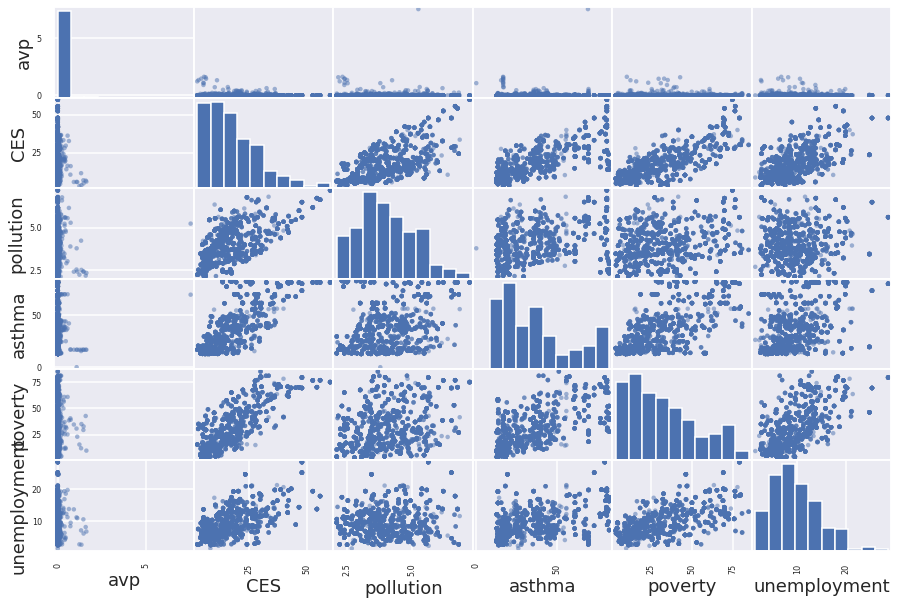

In [11]:
pd.plotting.scatter_matrix(df_health[['avp', 'CES', 'pollution', 'asthma', 'poverty', 'unemployment']], figsize=(15,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ab2f92110>,
      dtype=object)

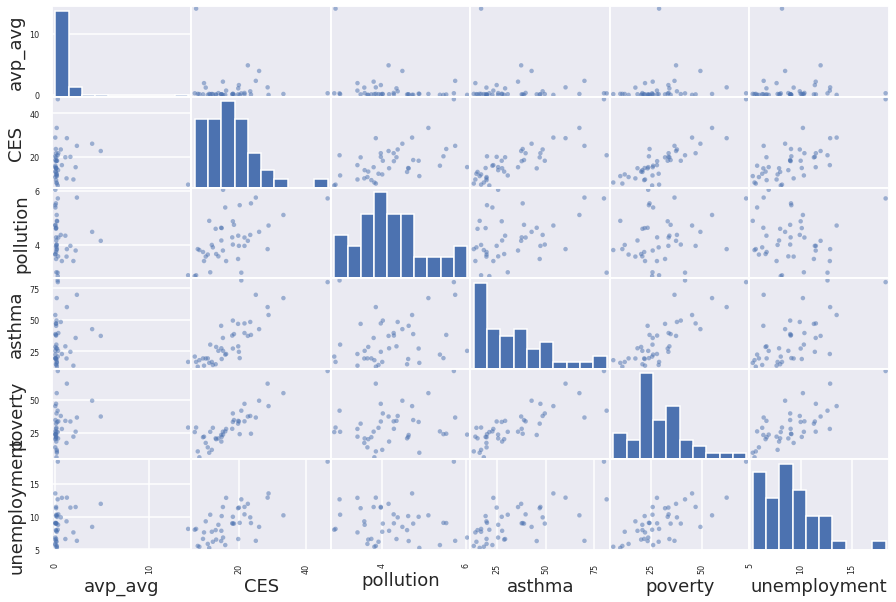

In [12]:
pd.plotting.scatter_matrix(df_zip[['avp_avg', 'CES', 'pollution', 'asthma', 'poverty', 'unemployment']], figsize=(15,10))

Both of the above scatterplot matrices show that the data is pretty fairly distributed, and that there is a noticeable correlation between CES and the other variables, affirming the plausibility of the data.

Below, I graphed the relationship between park acres vs. population and CES, with data being grouped by zip code. Ideally, park acres vs. total average population would account for the different proportions of parks to areas because of differing land sizes and the notion that a larger population requires more resources for sustenance. Thus, the graph should show how the prevalence of parks in an area impacts its overall environmental health.

(0.0, 50.0)

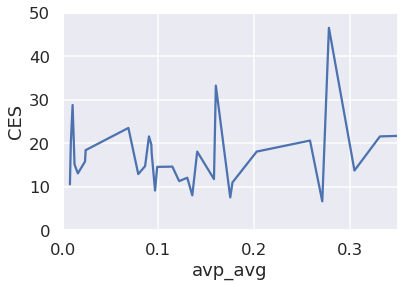

In [13]:
#graph of acres vs population and CES
plot1 = sns.lineplot(x=df_zip["avp_avg"], y=df_zip["CES"], data=df_zip)
plot1.set_xlim(0,0.35)
plot1.set_ylim(0,50)

In [23]:
outcome = df_zip["CES"]
predictor = df_zip["avp_avg"]
mod = sm.OLS(outcome, predictor)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                    CES   R-squared (uncentered):                   0.094
Model:                            OLS   Adj. R-squared (uncentered):              0.072
Method:                 Least Squares   F-statistic:                              4.255
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                      0.0455
Time:                        11:56:23   Log-Likelihood:                         -181.45
No. Observations:                  42   AIC:                                      364.9
Df Residuals:                      41   BIC:                                      366.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Ethics & Privacy

As stated previously, people's health may be impacted not only by the prevalence of parks in their area, but also other life factors such as employment and poverty, as higher unemployment rates or poorer areas may be associated with greater health risks due to stress and a relative lack of resource access. Additionally, low income areas and poverty-ridden areas are less likely to be able to afford parks and other environmentally beneficial commodities, so it would be biased and unethical to state that they are solely less healthy because they have less parks. For these reasons, I left in the aforementioned possible confounds in the environmental screening dataset, as they are necessary to explain inconsistencies or bias in the data. In terms of privacy, there were no detectable issues, as the datasets used are available to the public and the data within them does not contain any private or revealing information.

# Conclusion & Discussion

this section is unfinished